In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [16]:
seeds = [42, 55, 87, 1337]
instance_ids = [3, 111, 155]
class_dfs = { i : [] for i in instance_ids}
for s, i in itertools.product(seeds, instance_ids):
    df = pd.read_json(f"../analysis/final_analysis_11.02.22_17_18_21_{s}_{i}.jsonl", lines=True)
    class_dfs[i].append(df)
# find mean across seeds
mean_dfs = {}
for instance_idx, dfs in class_dfs.items():
    instance_df = pd.DataFrame(columns=dfs[0].columns)
    for i in range(len(dfs[0])): #all same length
        instance_df.loc[i] = dfs[0].iloc[i]
        instance_df.at[i, "precision"] = sum([df.iloc[i].precision for df in dfs]) / len(dfs)
        instance_df.at[i, "coverage"] = sum([df.iloc[i].coverage for df in dfs]) / len(dfs)
        instance_df.at[i, "n_samples"] = round(sum([df.iloc[i].n_samples for df in dfs]) / len(dfs))
        instance_df.at[i, "clock_time"] = round(sum([df.iloc[i].clock_time for df in dfs]) / len(dfs))
    mean_dfs[instance_idx] = instance_df

df = mean_dfs[155]
# reemove DNFs
df = df[~(df["clock_time"] == -1)]


### 3D Plots

In [17]:
# map precision values to colormap
# https://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib
minima = df["precision"].min()
maxima = df["precision"].max()
print(minima, maxima)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper_precision = cm.ScalarMappable(norm=norm, cmap="Dark2")
df["p_color"] = df["precision"].apply(lambda p : mapper_precision.to_rgba(p))

minima = df["coverage"].min()
maxima = df["coverage"].max()
print(minima, maxima)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper_cov = cm.ScalarMappable(norm=norm, cmap="inferno")
df["c_color"] = df["coverage"].apply(lambda p : mapper_cov.to_rgba(p))

minima = df["clock_time"].min()
maxima = df["clock_time"].max()
print(minima, maxima)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper_time = cm.ScalarMappable(norm=norm, cmap="gist_heat")
df["t_color"] = df["clock_time"].apply(lambda t : mapper_time.to_rgba(t))

0.9668170935623619 1.0
0.0352 0.21860000000000002
4 90


In [18]:
def animate(i):
    ax.view_init(azim=i)
    return fig,

def save_gif(fig, path):
    scatter_anim = animation.FuncAnimation(fig, animate, 360, blit=False)
    writer_gif = animation.PillowWriter(fps=10)
    scatter_anim.save(path, writer=writer_gif)
    print("gif saved")

save_gifs = True

gif saved


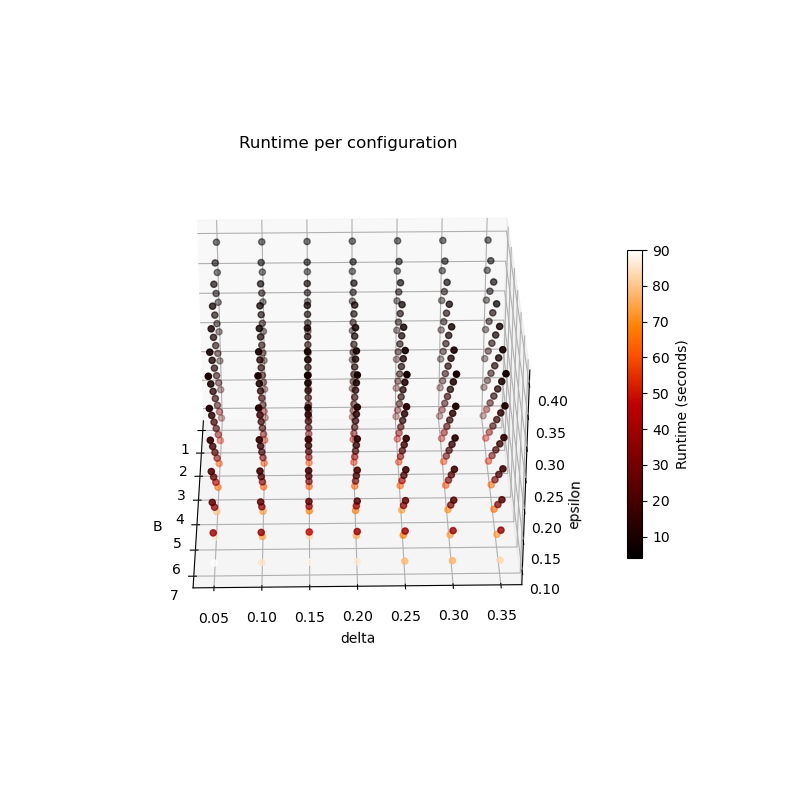

In [19]:
%matplotlib widget
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter3D(df["B"], df["delta"], df["epsilon"], marker="o", color=df["t_color"])
bar = fig.colorbar(mapper_time, shrink=0.5)
bar.set_label("Runtime (seconds)")
ax.set_xlabel('B')
ax.set_ylabel('delta')
ax.set_zlabel('epsilon')
ax.set_title("Runtime per configuration")

if save_gifs:
    f = r"../images/3d_scatter_runtime.gif"
    save_gif(fig, f)

gif saved


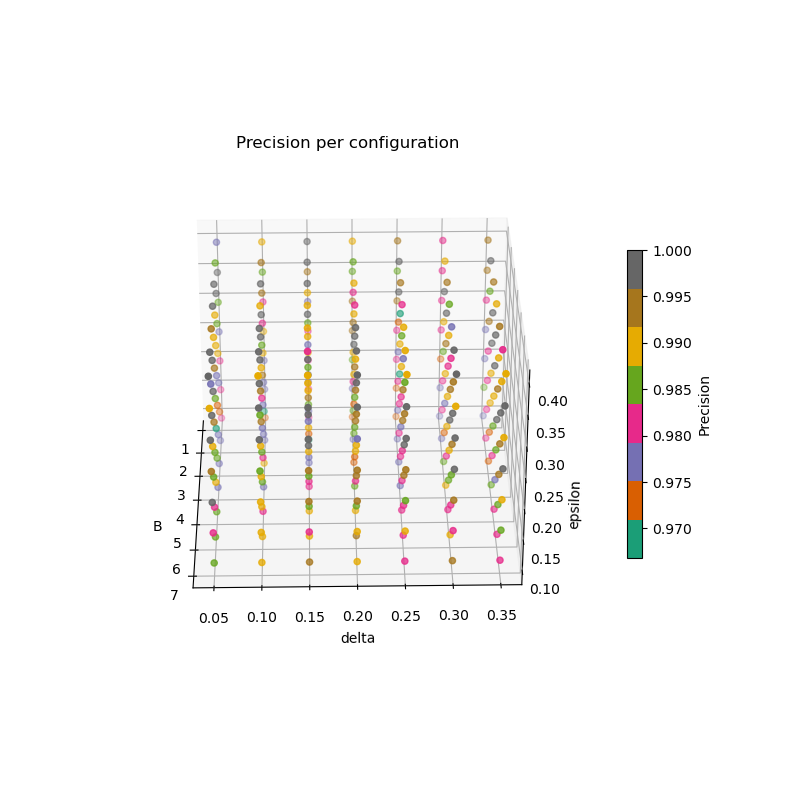

In [20]:
%matplotlib widget
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter3D(df["B"], df["delta"], df["epsilon"], marker="o", color=df["p_color"])
bar = fig.colorbar(mapper_precision, shrink=0.5)
bar.set_label("Precision")
ax.set_xlabel('B')
ax.set_ylabel('delta')
ax.set_zlabel('epsilon')
ax.set_title("Precision per configuration")

if save_gifs:
    f = r"../images/3d_scatter_precision.gif"
    save_gif(fig, f)

gif saved


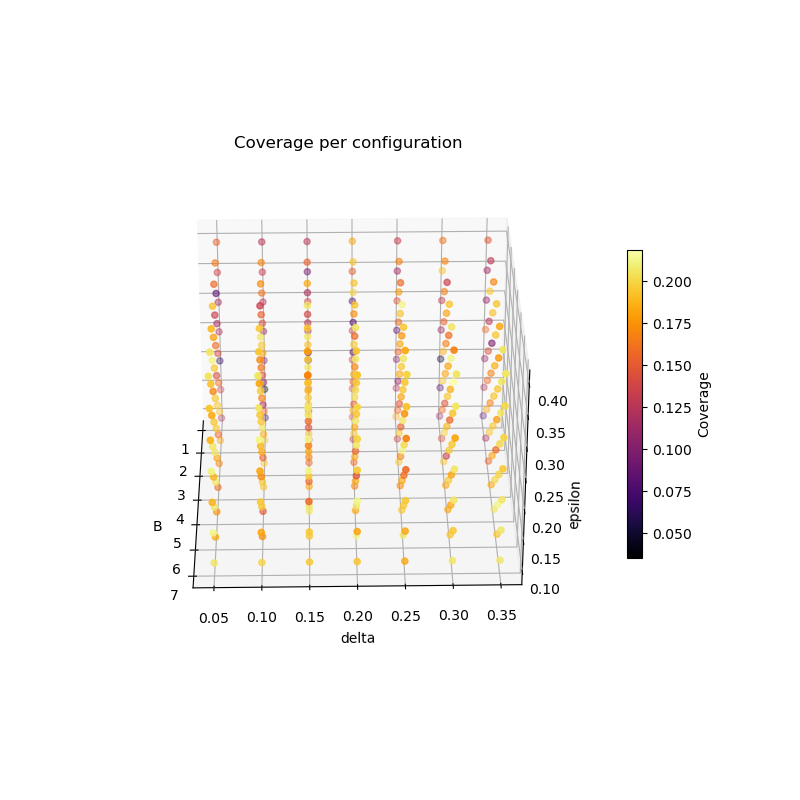

In [21]:
%matplotlib widget
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter3D(df["B"], df["delta"], df["epsilon"], marker="o", color=df["c_color"])
bar = fig.colorbar(mapper_cov, shrink=0.5)
bar.set_label("Coverage")
ax.set_xlabel('B')
ax.set_ylabel('delta')
ax.set_zlabel('epsilon')
ax.set_title("Coverage per configuration")

if save_gifs:
    f = r"../images/3d_scatter_coverage.gif"
    save_gif(fig, f)

### 2D Plots

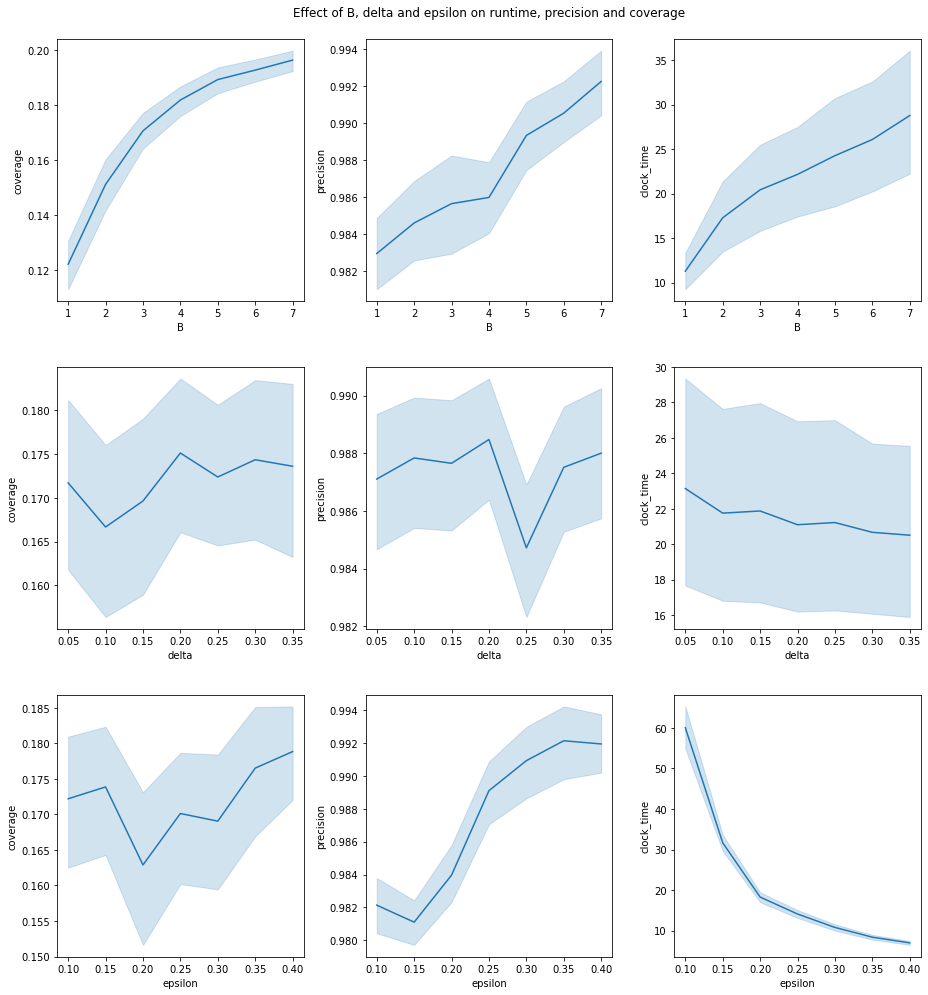

In [47]:
# global behaviour of delta and eps
%matplotlib inline
fig, axs = plt.subplots(3,3, figsize=(15,15))
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.25, 
                    hspace=0.25)

fig = sns.lineplot(x=df["B"], y=df["coverage"], ax=axs[0,0])
fig = sns.lineplot(x=df["B"], y=df["precision"], ax=axs[0,1])
fig = sns.lineplot(x=df["B"], y=df["clock_time"], ax=axs[0,2])
fig = sns.lineplot(x=df["delta"], y=df["coverage"], ax=axs[1,0])
fig = sns.lineplot(x=df["delta"], y=df["precision"], ax=axs[1,1])
fig = sns.lineplot(x=df["delta"], y=df["clock_time"], ax=axs[1,2])
fig = sns.lineplot(x=df["epsilon"], y=df["coverage"], ax=axs[2,0])
fig = sns.lineplot(x=df["epsilon"], y=df["precision"], ax=axs[2,1])
fig = sns.lineplot(x=df["epsilon"], y=df["clock_time"], ax=axs[2,2])
plt.suptitle("Effect of B, delta and epsilon on runtime, precision and coverage")
plt.show()


### Trajectory

In [ ]:
# based on https://benalexkeen.com/parallel-coordinates-in-matplotlib/
# Each segment is one anchor search iteration, y-axis is precision, colors are n_samples
df = pd.read_json("../analysis/final_analysis_11.02.22_17_18_21_42_3.jsonl", lines=True)
# pnc indice mapping
pnc = {"precision" : 0, "n_samples" : 1, "coverage" : 2}
print(len(df))
run_id = 245

B = df.iloc[run_id].B
attribute = "precision"
hue = "coverage"


trajectory = df.iloc[run_id].trajectory_pnc
# trajectory is list of lists (algorithm iters) of lists (b-candidates: prec , samples, coverage)
cols = []
for i in range(len(trajectory)):
    cols.append(f"attr_iter {i}")
    cols.append(f"hue_iter {i}")
t = pd.DataFrame(columns=cols)
# t has B entries

rows = {b : [] for b in range(B)}
for iteration, b_best in enumerate(trajectory):
    for b, candidate in enumerate(b_best):
        rows[b].append(candidate[pnc[attribute]])
        rows[b].append(candidate[pnc[hue]])
        # check whthe r we actually have B items
        if not len(b_best) == B:
            for missing in range(B-len(b_best)):
                rows[(B - 1) - missing].append(0)
                rows[(B - 1) - missing].append(0)
        

for row in rows.values():
    print(row)
    t.loc[len(t.index)] = row
# code below on df
df = t

In [ ]:
from matplotlib import ticker

cols = [f"attr_iter {i}" for i in range(len(trajectory))]
x = [i for i, _ in enumerate(cols)]

# setup colors
minima = min([df[f"hue_iter {i}"].min() for i in range(len(cols))])
maxima = max([df[f"hue_iter {i}"].max() for i in range(len(cols))])

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper_cov = cm.ScalarMappable(norm=norm, cmap="Blues")
for i in range(len(cols)):
    df[f"hue_iter {i}"] = df[f"hue_iter {i}"].apply(lambda p : mapper_cov.to_rgba(p))

# 
# Create (X-1) sublots along x axis
fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

# Get min, max and range for each column
# Normalize the data for each column
min_max_range = {}
for col in cols:
    min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
    df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

# Plot each row
for i, ax in enumerate(axes):
    for idx in df.index:
        mpg_category = df.loc[idx, f"attr_iter {i}"]
        ax.plot(x, df.loc[idx, cols], c=df.loc[idx, f"hue_iter {i}"])
        #print(df.loc[idx, "hue_iter 0"])
    ax.set_xlim([x[i], x[i+1]])
    
# Set the tick positions and labels on y axis for each plot
# Tick positions based on normalised data
# Tick labels are based on original data
def set_ticks_for_axis(dim, ax, ticks):
    min_val, max_val, val_range = min_max_range[cols[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
    norm_min = df[cols[dim]].min()
    norm_range = np.ptp(df[cols[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels)

for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[dim]])
    

# Move the final axis' ticks to the right-hand side
ax = plt.twinx(axes[-1])
dim = len(axes)
ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
set_ticks_for_axis(dim, ax, ticks=6)
ax.set_xticklabels([cols[-2], cols[-1]])


# Remove space between subplots
plt.subplots_adjust(wspace=0)

# Add legend to plot
#plt.legend(
#    [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df['attr_iter 0'].cat.categories],
#    df['attr_iter 0'].cat.categories,
#    bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

plt.title("Beam search trajectory, each line portrays one candidate.")
plt.colorbar(mapper_cov, shrink=0.8, label=hue, pad=0.2)

plt.show()